In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from scipy import stats

In [2]:
def adj_r2(score, x_data):
    return 1 - (1 - score) * (x_data.shape[0] - 1) / (x_data.shape[0] - x_data.shape[1] - 1)

In [3]:
def diagnostic_plots(x, y, y_pred):    
    
    plt.figure(figsize=(20,6))
    plt.tight_layout(pad=10.0)
    
    plt.subplot(1, 3, 1)
    plt.scatter(y_pred,y)
    plt.plot([0, 9e6], [0, 9e6], color='r', linestyle='-')
    plt.title('Actual vs. True Sale Price', size=18)
    plt.xlabel('Predicted Sale Price', size=16)
    plt.ylabel('Actual Sale Price', size=16)
    plt.xticks(size=12)
    plt.yticks(size=12)
    
    plt.subplot(1, 3, 2)
    res = y - y_pred
    plt.scatter(y_pred, res)
    plt.axhline(y=0.0, color='r', linestyle='-')
    plt.title('Residuals Plot', size=18)
    plt.xlabel('Predicted', size=16)
    plt.ylabel('Residual', size=16)
    plt.xticks(size=12)
    plt.yticks(size=12)
    
    plt.subplot(1, 3, 3)
    # specified theoretical distribution 
    stats.probplot(res, dist='norm', plot=plt)
    plt.title('Normal Q-Q plot', size=18)
    plt.xlabel('Theoretical Quantiles', size=16)
    plt.ylabel('Ordered Values', size=16)
    plt.xticks(size=12)
    plt.yticks(size=12)

In [4]:
df=pd.read_csv('../01_data_collection/redfin_data.csv')
df.shape

(1656, 23)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sold Price         1649 non-null   float64
 1   Beds               1649 non-null   float64
 2   Baths              1649 non-null   float64
 3   Floors             1632 non-null   float64
 4   Garage Spaces      1656 non-null   int64  
 5   Lot Size (sq ft)   1653 non-null   float64
 6   Home Size (sq ft)  1655 non-null   float64
 7   Year Built         1653 non-null   float64
 8   School Score Avg   1515 non-null   float64
 9   Walk Score         1538 non-null   float64
 10  Transit Score      1538 non-null   float64
 11  Bike Score         1538 non-null   float64
 12  Laundry            1656 non-null   bool   
 13  Heating            1656 non-null   bool   
 14  Air Conditioning   1656 non-null   bool   
 15  Pool               1656 non-null   bool   
 16  Address            1656 

In [6]:
## DATA CLEANING

df.drop(columns=['Address', 'Sold Status', 'URL'], inplace = True)

df = df.dropna()
df.reset_index(drop=True, inplace=True)

df.columns= df.columns.str.lower()
df.rename(columns={'lot size (sq ft)': 'lot size', 'home size (sq ft)': 'home size'}, inplace=True)

df.drop(df.index[df['city'] == 'SAN JOSE'], inplace=True)

df.drop(df.index[df['city'] == 'EAST PALO ALTO'], inplace=True)

df.drop(df.index[df['county'] == 'SAN MATEO COUNTY'], inplace=True)

df.drop(columns=['county', 'zip code', 'property type'], inplace = True)

df['age of house'] = (df['year built'].max() + 1) - df['year built']


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 0 to 1439
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sold price        1297 non-null   float64
 1   beds              1297 non-null   float64
 2   baths             1297 non-null   float64
 3   floors            1297 non-null   float64
 4   garage spaces     1297 non-null   int64  
 5   lot size          1297 non-null   float64
 6   home size         1297 non-null   float64
 7   year built        1297 non-null   float64
 8   school score avg  1297 non-null   float64
 9   walk score        1297 non-null   float64
 10  transit score     1297 non-null   float64
 11  bike score        1297 non-null   float64
 12  laundry           1297 non-null   bool   
 13  heating           1297 non-null   bool   
 14  air conditioning  1297 non-null   bool   
 15  pool              1297 non-null   bool   
 16  city              1297 non-null   object 


In [8]:
## PRELIMINARY EDA & FEATURE EXPLORATION

In [9]:
df_temp = df.drop(columns=['year built', 'walk score', 'transit score', 'bike score',
                           'city', 'laundry', 'heating', 'air conditioning', 'pool'])

In [10]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 0 to 1439
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sold price        1297 non-null   float64
 1   beds              1297 non-null   float64
 2   baths             1297 non-null   float64
 3   floors            1297 non-null   float64
 4   garage spaces     1297 non-null   int64  
 5   lot size          1297 non-null   float64
 6   home size         1297 non-null   float64
 7   school score avg  1297 non-null   float64
 8   age of house      1297 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 101.3 KB


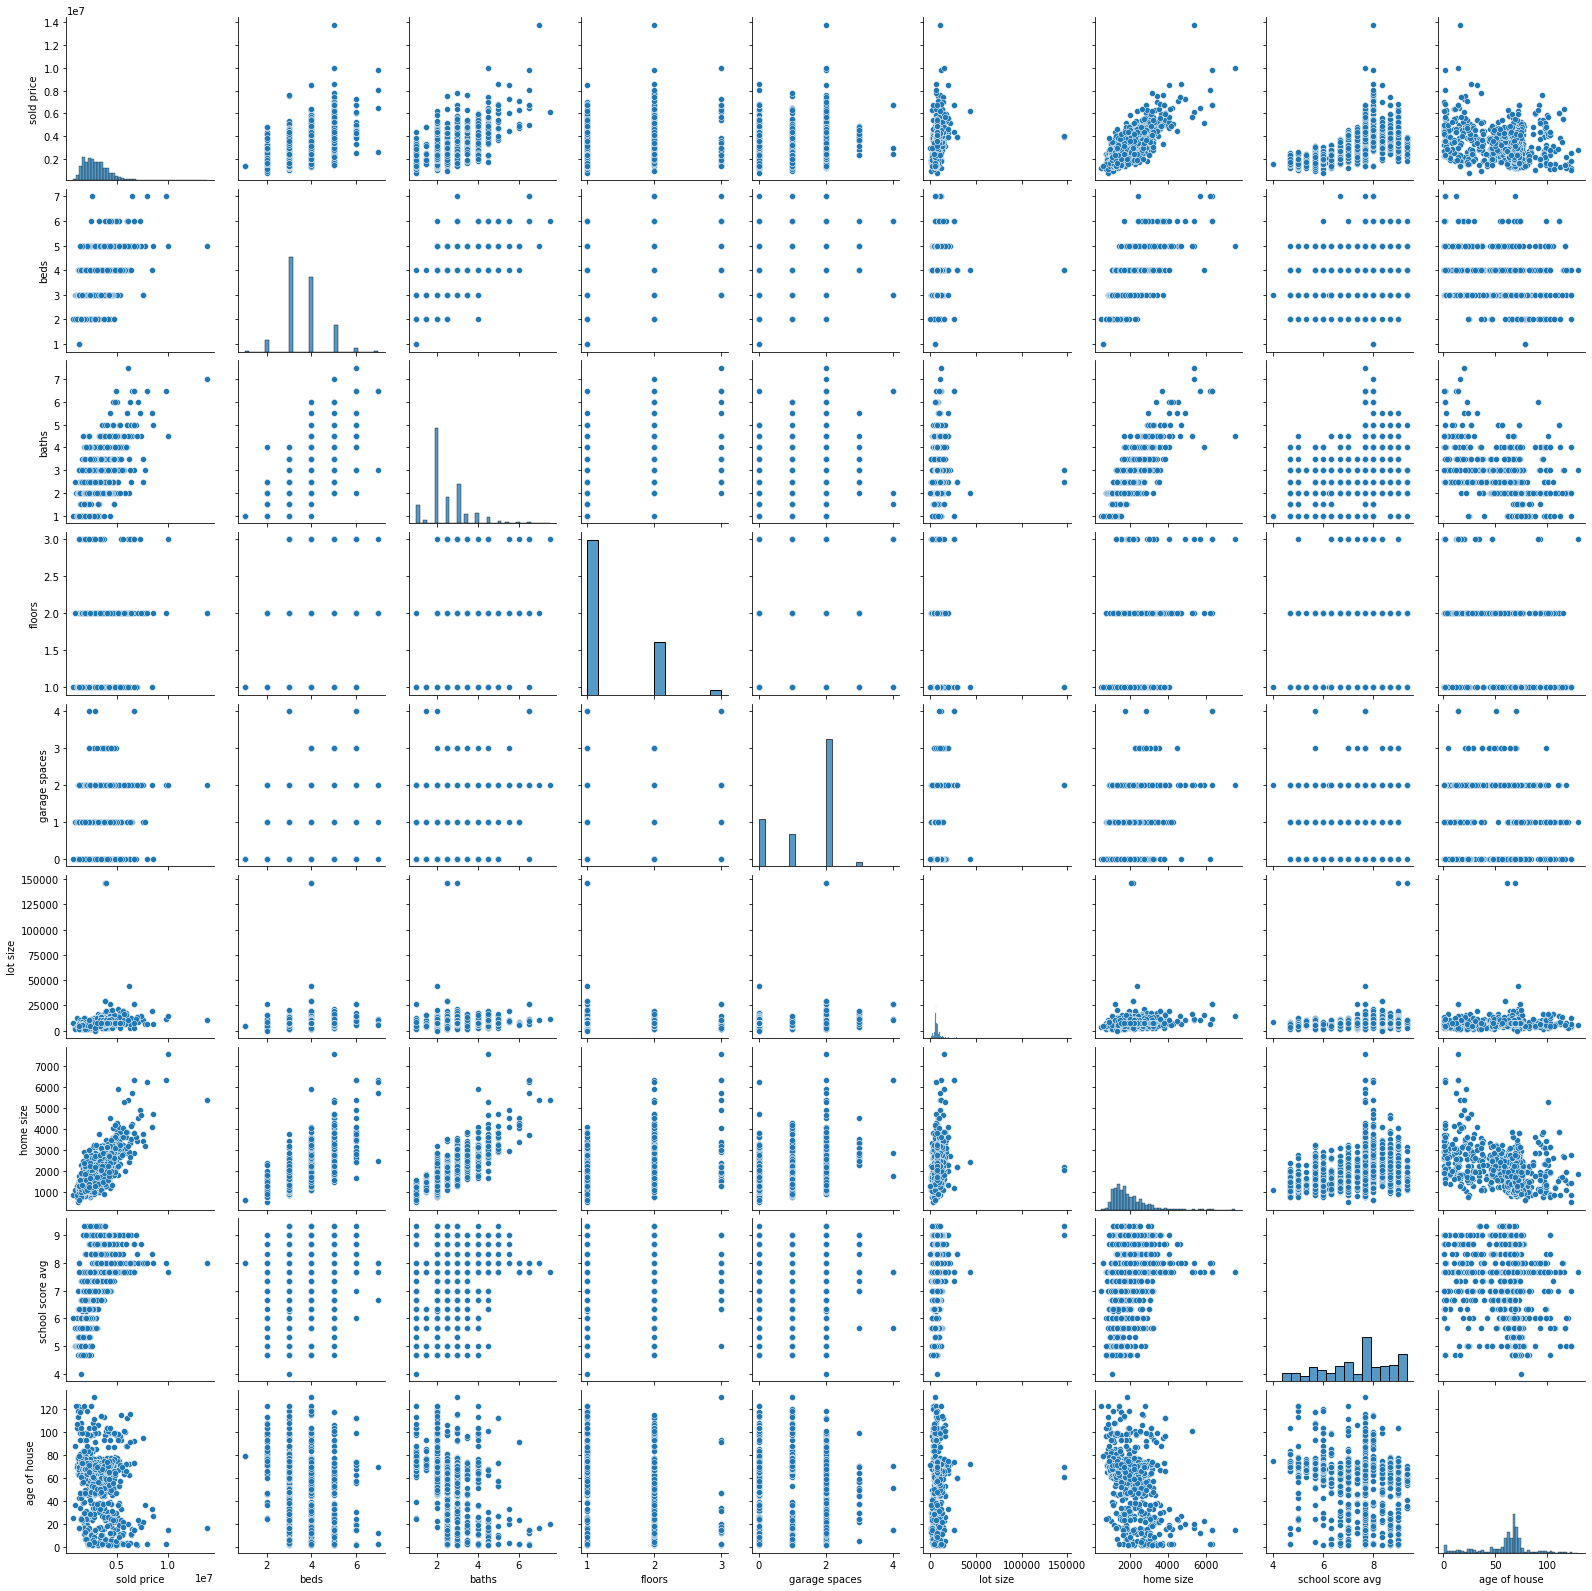

In [11]:
sns.pairplot(df_temp);

In [12]:
df_temp.describe()

,sold price,beds,baths,floors,garage spaces,lot size,home size,school score avg,age of house
count,1.297000e+03,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000
mean,3.042164e+06,3.616037,2.471087,1.292213,1.432537,7585.062162,1900.579800,7.297738,59.685428
std,1.260630e+06,0.869043,0.937748,0.500194,0.867070,6370.413927,786.008148,1.248811,22.462171
min,7.750000e+05,1.000000,1.000000,1.000000,0.000000,0.000000,528.000000,4.000000,1.000000
25%,2.100000e+06,3.000000,2.000000,1.000000,1.000000,5684.580000,1357.000000,6.333333,55.000000
50%,2.828000e+06,4.000000,2.000000,1.000000,2.000000,6682.104000,1740.000000,7.666667,66.000000
75%,3.709113e+06,4.000000,3.000000,2.000000,2.000000,8319.960000,2264.000000,8.333333,70.000000
max,1.380700e+07,7.000000,7.500000,3.000000,4.000000,146361.600000,7536.000000,9.333333,130.000000


In [13]:
df['city'].unique()

array(['PALO ALTO', 'LOS ALTOS', 'MOUNTAIN VIEW', 'SUNNYVALE',
       'SANTA CLARA', 'CUPERTINO'], dtype=object)

In [14]:
df.sort_values(by=['sold price'], ascending=False)

,sold price,beds,baths,floors,garage spaces,lot size,home size,year built,school score avg,walk score,transit score,bike score,laundry,heating,air conditioning,pool,city,age of house
126,13807000.0,5.0,7.0,2.0,2,10497.960,5366.0,2007.0,8.000000,59.0,38.0,96.0,True,True,True,True,PALO ALTO,16.0
1326,10000000.0,5.0,4.5,3.0,2,14671.008,7536.0,2009.0,7.666667,49.0,40.0,81.0,True,True,True,True,LOS ALTOS,14.0
105,9800000.0,7.0,6.5,2.0,2,11913.660,6304.0,2021.0,8.000000,40.0,35.0,75.0,True,True,True,True,PALO ALTO,2.0
344,8592002.0,5.0,5.0,2.0,0,6734.376,4708.0,1996.0,8.000000,44.0,35.0,70.0,False,False,False,True,PALO ALTO,27.0
1325,8500000.0,4.0,5.5,1.0,2,19074.924,4079.0,1990.0,8.333333,69.0,25.0,98.0,True,True,True,True,LOS ALTOS,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201,1105000.0,2.0,1.0,1.0,1,4321.152,864.0,1916.0,5.666667,74.0,43.0,92.0,True,True,True,False,SANTA CLARA,107.0
1085,1020000.0,3.0,2.0,1.0,0,4499.748,880.0,1900.0,5.000000,69.0,50.0,75.0,False,True,False,True,SANTA CLARA,123.0
1036,1000000.0,3.0,1.0,1.0,1,3384.612,937.0,1935.0,5.000000,58.0,41.0,55.0,True,True,True,True,SANTA CLARA,88.0
1187,928000.0,2.0,2.5,2.0,1,1097.712,1126.0,1987.0,5.666667,88.0,50.0,91.0,True,True,True,True,SANTA CLARA,36.0


In [15]:
df.drop([126], inplace=True)
df.sort_values(by=['sold price'], ascending=False)

,sold price,beds,baths,floors,garage spaces,lot size,home size,year built,school score avg,walk score,transit score,bike score,laundry,heating,air conditioning,pool,city,age of house
1326,10000000.0,5.0,4.5,3.0,2,14671.008,7536.0,2009.0,7.666667,49.0,40.0,81.0,True,True,True,True,LOS ALTOS,14.0
105,9800000.0,7.0,6.5,2.0,2,11913.660,6304.0,2021.0,8.000000,40.0,35.0,75.0,True,True,True,True,PALO ALTO,2.0
344,8592002.0,5.0,5.0,2.0,0,6734.376,4708.0,1996.0,8.000000,44.0,35.0,70.0,False,False,False,True,PALO ALTO,27.0
1325,8500000.0,4.0,5.5,1.0,2,19074.924,4079.0,1990.0,8.333333,69.0,25.0,98.0,True,True,True,True,LOS ALTOS,33.0
327,8010300.0,7.0,6.5,2.0,0,6734.376,6200.0,2021.0,8.000000,0.0,0.0,2.0,False,False,False,True,PALO ALTO,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201,1105000.0,2.0,1.0,1.0,1,4321.152,864.0,1916.0,5.666667,74.0,43.0,92.0,True,True,True,False,SANTA CLARA,107.0
1085,1020000.0,3.0,2.0,1.0,0,4499.748,880.0,1900.0,5.000000,69.0,50.0,75.0,False,True,False,True,SANTA CLARA,123.0
1036,1000000.0,3.0,1.0,1.0,1,3384.612,937.0,1935.0,5.000000,58.0,41.0,55.0,True,True,True,True,SANTA CLARA,88.0
1187,928000.0,2.0,2.5,2.0,1,1097.712,1126.0,1987.0,5.666667,88.0,50.0,91.0,True,True,True,True,SANTA CLARA,36.0


In [16]:
df.sort_values(by=['lot size'], ascending=False)

,sold price,beds,baths,floors,garage spaces,lot size,home size,year built,school score avg,walk score,transit score,bike score,laundry,heating,air conditioning,pool,city,age of house
951,3888000.0,4.0,3.0,1.0,2,146361.600,2187.0,1962.0,9.333333,13.0,0.0,24.0,True,True,True,True,CUPERTINO,61.0
952,3950000.0,4.0,2.5,1.0,2,146361.600,2071.0,1954.0,9.000000,44.0,19.0,52.0,True,True,False,True,CUPERTINO,69.0
165,6200000.0,4.0,2.0,1.0,0,43703.748,2411.0,1951.0,7.666667,30.0,32.0,77.0,True,True,True,False,PALO ALTO,72.0
948,3900000.0,4.0,2.5,1.0,2,28880.280,2182.0,1963.0,8.333333,10.0,20.0,26.0,True,True,True,True,LOS ALTOS,60.0
866,3900000.0,4.0,2.5,1.0,2,28880.280,2182.0,1963.0,8.333333,10.0,20.0,26.0,True,True,True,True,LOS ALTOS,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1884020.0,3.0,3.5,3.0,2,1398.276,2231.0,2010.0,7.666667,65.0,39.0,72.0,True,True,True,True,SANTA CLARA,13.0
800,1818000.0,4.0,3.5,2.0,2,1319.868,1725.0,2007.0,4.666667,51.0,41.0,73.0,True,True,True,True,SUNNYVALE,16.0
494,1600000.0,3.0,3.5,3.0,2,1306.800,1612.0,2007.0,7.333333,56.0,37.0,85.0,True,True,True,False,MOUNTAIN VIEW,16.0
1187,928000.0,2.0,2.5,2.0,1,1097.712,1126.0,1987.0,5.666667,88.0,50.0,91.0,True,True,True,True,SANTA CLARA,36.0


In [17]:
df.drop([951,952, 165], inplace=True)
df.sort_values(by=['lot size'], ascending=False)

,sold price,beds,baths,floors,garage spaces,lot size,home size,year built,school score avg,walk score,transit score,bike score,laundry,heating,air conditioning,pool,city,age of house
1383,3900000.0,4.0,2.5,1.0,2,28880.280,2182.0,1963.0,8.333333,10.0,20.0,26.0,True,True,True,True,LOS ALTOS,60.0
866,3900000.0,4.0,2.5,1.0,2,28880.280,2182.0,1963.0,8.333333,10.0,20.0,26.0,True,True,True,True,LOS ALTOS,60.0
948,3900000.0,4.0,2.5,1.0,2,28880.280,2182.0,1963.0,8.333333,10.0,20.0,26.0,True,True,True,True,LOS ALTOS,60.0
1418,6700000.0,6.0,6.5,3.0,4,25944.336,6338.0,2009.0,7.666667,22.0,36.0,80.0,True,True,True,True,LOS ALTOS,14.0
293,6700000.0,6.0,6.5,3.0,4,25944.336,6338.0,2009.0,7.666667,22.0,36.0,80.0,True,True,True,True,LOS ALTOS,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1884020.0,3.0,3.5,3.0,2,1398.276,2231.0,2010.0,7.666667,65.0,39.0,72.0,True,True,True,True,SANTA CLARA,13.0
800,1818000.0,4.0,3.5,2.0,2,1319.868,1725.0,2007.0,4.666667,51.0,41.0,73.0,True,True,True,True,SUNNYVALE,16.0
494,1600000.0,3.0,3.5,3.0,2,1306.800,1612.0,2007.0,7.333333,56.0,37.0,85.0,True,True,True,False,MOUNTAIN VIEW,16.0
1187,928000.0,2.0,2.5,2.0,1,1097.712,1126.0,1987.0,5.666667,88.0,50.0,91.0,True,True,True,True,SANTA CLARA,36.0


In [18]:
df.sort_values(by=['lot size'], ascending=True)

,sold price,beds,baths,floors,garage spaces,lot size,home size,year built,school score avg,walk score,transit score,bike score,laundry,heating,air conditioning,pool,city,age of house
1410,2950000.0,2.0,2.0,1.0,0,0.000,1318.0,1952.0,8.333333,87.0,27.0,97.0,True,True,False,True,LOS ALTOS,71.0
1187,928000.0,2.0,2.5,2.0,1,1097.712,1126.0,1987.0,5.666667,88.0,50.0,91.0,True,True,True,True,SANTA CLARA,36.0
494,1600000.0,3.0,3.5,3.0,2,1306.800,1612.0,2007.0,7.333333,56.0,37.0,85.0,True,True,True,False,MOUNTAIN VIEW,16.0
800,1818000.0,4.0,3.5,2.0,2,1319.868,1725.0,2007.0,4.666667,51.0,41.0,73.0,True,True,True,True,SUNNYVALE,16.0
1256,1884020.0,3.0,3.5,3.0,2,1398.276,2231.0,2010.0,7.666667,65.0,39.0,72.0,True,True,True,True,SANTA CLARA,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,6700000.0,6.0,6.5,3.0,4,25944.336,6338.0,2009.0,7.666667,22.0,36.0,80.0,True,True,True,True,LOS ALTOS,14.0
1418,6700000.0,6.0,6.5,3.0,4,25944.336,6338.0,2009.0,7.666667,22.0,36.0,80.0,True,True,True,True,LOS ALTOS,14.0
1383,3900000.0,4.0,2.5,1.0,2,28880.280,2182.0,1963.0,8.333333,10.0,20.0,26.0,True,True,True,True,LOS ALTOS,60.0
948,3900000.0,4.0,2.5,1.0,2,28880.280,2182.0,1963.0,8.333333,10.0,20.0,26.0,True,True,True,True,LOS ALTOS,60.0


In [19]:
df.drop([1410], inplace=True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1292 entries, 0 to 1439
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sold price        1292 non-null   float64
 1   beds              1292 non-null   float64
 2   baths             1292 non-null   float64
 3   floors            1292 non-null   float64
 4   garage spaces     1292 non-null   int64  
 5   lot size          1292 non-null   float64
 6   home size         1292 non-null   float64
 7   year built        1292 non-null   float64
 8   school score avg  1292 non-null   float64
 9   walk score        1292 non-null   float64
 10  transit score     1292 non-null   float64
 11  bike score        1292 non-null   float64
 12  laundry           1292 non-null   bool   
 13  heating           1292 non-null   bool   
 14  air conditioning  1292 non-null   bool   
 15  pool              1292 non-null   bool   
 16  city              1292 non-null   object 


In [21]:
# 'bucket' observations for beds [1, 2, 3, 4, 5, 6+] -> dummy variables?
df['beds'].value_counts()

3.0    576
4.0    454
5.0    163
2.0     69
6.0     24
7.0      4
1.0      2
Name: beds, dtype: int64

In [22]:
# 'bucket' observations for baths [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5+] -> dummy variables?
df['baths'].value_counts()

2.0    581
3.0    238
2.5    160
1.0    109
4.0     59
3.5     56
4.5     37
1.5     21
5.0     15
6.5      6
6.0      5
5.5      4
7.5      1
Name: baths, dtype: int64

In [23]:
# dummy variables?
df['floors'].value_counts()

1.0    942
2.0    322
3.0     28
Name: floors, dtype: int64

In [24]:
# 'bucket' observations for garage spaces [0, 1, 2, 3+] -> dummy variables?
df['garage spaces'].value_counts()

2    775
0    285
1    199
3     29
4      4
Name: garage spaces, dtype: int64

In [25]:
df.corr()

,sold price,beds,baths,floors,garage spaces,lot size,home size,year built,school score avg,walk score,transit score,bike score,laundry,heating,air conditioning,pool,age of house
sold price,1.000000,0.531021,0.611212,0.297503,0.074380,0.498879,0.777310,0.263180,0.638529,-0.271175,-0.351610,0.057118,0.029400,-0.053217,0.031581,0.101150,-0.263180
beds,0.531021,1.000000,0.685153,0.419474,0.158941,0.296403,0.729654,0.314195,0.245420,-0.249011,-0.232806,-0.119324,0.040612,0.048950,0.156098,0.073836,-0.314195
baths,0.611212,0.685153,1.000000,0.517345,0.108519,0.245590,0.825479,0.467802,0.247908,-0.165861,-0.166837,-0.026415,0.028379,-0.005497,0.202484,0.061521,-0.467802
floors,0.297503,0.419474,0.517345,1.000000,0.100308,-0.049014,0.536402,0.487974,0.141928,-0.081550,-0.024067,0.007950,0.043236,0.039263,0.174223,0.046934,-0.487974
garage spaces,0.074380,0.158941,0.108519,0.100308,1.000000,0.220407,0.153854,0.156493,0.065372,-0.125653,-0.098849,-0.173482,0.142718,0.738772,0.442543,0.061571,-0.156493
lot size,0.498879,0.296403,0.245590,-0.049014,0.220407,1.000000,0.404453,-0.038314,0.342707,-0.291233,-0.318347,-0.215212,-0.018264,0.127620,0.061190,0.079917,0.038314
home size,0.777310,0.729654,0.825479,0.536402,0.153854,0.404453,1.000000,0.437768,0.353373,-0.227865,-0.236427,-0.052847,0.031403,0.004105,0.190102,0.098964,-0.437768
year built,0.263180,0.314195,0.467802,0.487974,0.156493,-0.038314,0.437768,1.000000,0.133315,-0.144097,-0.123981,-0.050610,0.015244,0.035373,0.213367,0.054423,-1.000000
school score avg,0.638529,0.245420,0.247908,0.141928,0.065372,0.342707,0.353373,0.133315,1.000000,-0.336660,-0.488085,-0.037512,-0.050106,-0.037115,-0.052381,0.143565,-0.133315
walk score,-0.271175,-0.249011,-0.165861,-0.081550,-0.125653,-0.291233,-0.227865,-0.144097,-0.336660,1.000000,0.587011,0.609628,0.008732,-0.004716,-0.012378,-0.058871,0.144097


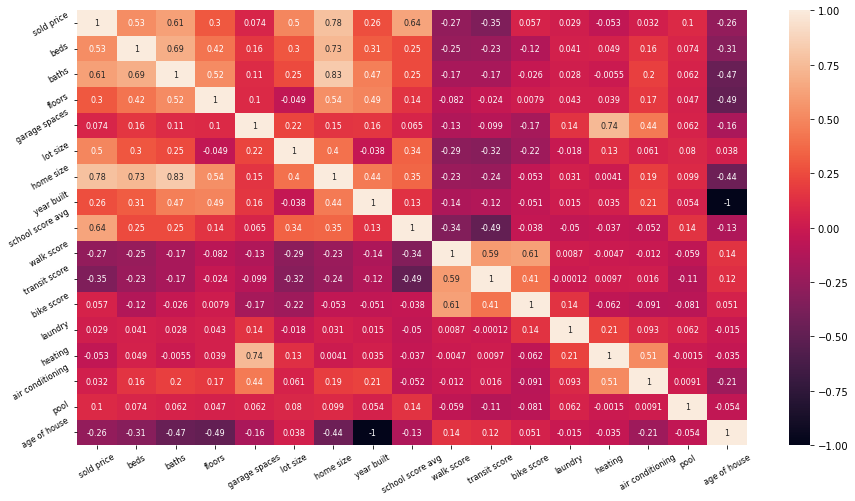

In [26]:
plt.figure(figsize=(15,8))

ax = sns.heatmap(df.corr(), annot=True, annot_kws={'size':8})
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, size=8)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30, size=8);

In [27]:
df.drop(columns=['year built'], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1292 entries, 0 to 1439
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sold price        1292 non-null   float64
 1   beds              1292 non-null   float64
 2   baths             1292 non-null   float64
 3   floors            1292 non-null   float64
 4   garage spaces     1292 non-null   int64  
 5   lot size          1292 non-null   float64
 6   home size         1292 non-null   float64
 7   school score avg  1292 non-null   float64
 8   walk score        1292 non-null   float64
 9   transit score     1292 non-null   float64
 10  bike score        1292 non-null   float64
 11  laundry           1292 non-null   bool   
 12  heating           1292 non-null   bool   
 13  air conditioning  1292 non-null   bool   
 14  pool              1292 non-null   bool   
 15  city              1292 non-null   object 
 16  age of house      1292 non-null   float64


In [28]:
df.describe()

,sold price,beds,baths,floors,garage spaces,lot size,home size,school score avg,walk score,transit score,bike score,age of house
count,1.292000e+03,1292.000000,1292.000000,1292.00000,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000,1292.000000
mean,3.030102e+06,3.615325,2.467879,1.29257,1.433437,7345.898387,1897.599845,7.293215,55.627709,36.523220,78.616873,59.692724
std,1.223321e+06,0.868511,0.930762,0.50051,0.866484,3128.064781,781.242430,1.248509,18.792889,8.473877,13.008409,22.466414
min,7.750000e+05,1.000000,1.000000,1.00000,0.000000,1097.712000,528.000000,4.000000,0.000000,0.000000,2.000000,1.000000
25%,2.100000e+06,3.000000,2.000000,1.00000,1.000000,5684.580000,1355.250000,6.333333,43.000000,32.000000,71.000000,55.000000
50%,2.827364e+06,3.000000,2.000000,1.00000,2.000000,6682.104000,1739.000000,7.666667,58.000000,38.000000,78.000000,66.000000
75%,3.700000e+06,4.000000,3.000000,2.00000,2.000000,8269.866000,2263.250000,8.333333,70.000000,42.000000,88.000000,70.000000
max,1.000000e+07,7.000000,7.500000,3.00000,4.000000,28880.280000,7536.000000,9.333333,95.000000,58.000000,100.000000,130.000000


In [29]:
df['walk score'].sort_values()

327     0.0
965     3.0
882     7.0
346     7.0
873     8.0
       ... 
623    93.0
561    93.0
336    93.0
244    95.0
462    95.0
Name: walk score, Length: 1292, dtype: float64

In [30]:
df['transit score'].sort_values()

895      0.0
953      0.0
327      0.0
1320     0.0
882      0.0
        ... 
522     53.0
562     53.0
509     55.0
366     55.0
315     58.0
Name: transit score, Length: 1292, dtype: float64

In [31]:
df['bike score'].sort_values()

327       2.0
1354     20.0
948      26.0
1383     26.0
866      26.0
        ...  
132     100.0
187     100.0
326     100.0
321     100.0
452     100.0
Name: bike score, Length: 1292, dtype: float64

In [32]:
df_temp = df.drop(columns=['walk score', 'transit score', 'bike score'])

In [33]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1292 entries, 0 to 1439
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sold price        1292 non-null   float64
 1   beds              1292 non-null   float64
 2   baths             1292 non-null   float64
 3   floors            1292 non-null   float64
 4   garage spaces     1292 non-null   int64  
 5   lot size          1292 non-null   float64
 6   home size         1292 non-null   float64
 7   school score avg  1292 non-null   float64
 8   laundry           1292 non-null   bool   
 9   heating           1292 non-null   bool   
 10  air conditioning  1292 non-null   bool   
 11  pool              1292 non-null   bool   
 12  city              1292 non-null   object 
 13  age of house      1292 non-null   float64
dtypes: bool(4), float64(8), int64(1), object(1)
memory usage: 116.1+ KB


In [34]:
bool_cols = {
                'laundry': int,
                'heating': int,
                'air conditioning': int,
                'pool': int
               }
  
df_temp = df_temp.astype(bool_cols)
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1292 entries, 0 to 1439
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sold price        1292 non-null   float64
 1   beds              1292 non-null   float64
 2   baths             1292 non-null   float64
 3   floors            1292 non-null   float64
 4   garage spaces     1292 non-null   int64  
 5   lot size          1292 non-null   float64
 6   home size         1292 non-null   float64
 7   school score avg  1292 non-null   float64
 8   laundry           1292 non-null   int64  
 9   heating           1292 non-null   int64  
 10  air conditioning  1292 non-null   int64  
 11  pool              1292 non-null   int64  
 12  city              1292 non-null   object 
 13  age of house      1292 non-null   float64
dtypes: float64(8), int64(5), object(1)
memory usage: 151.4+ KB


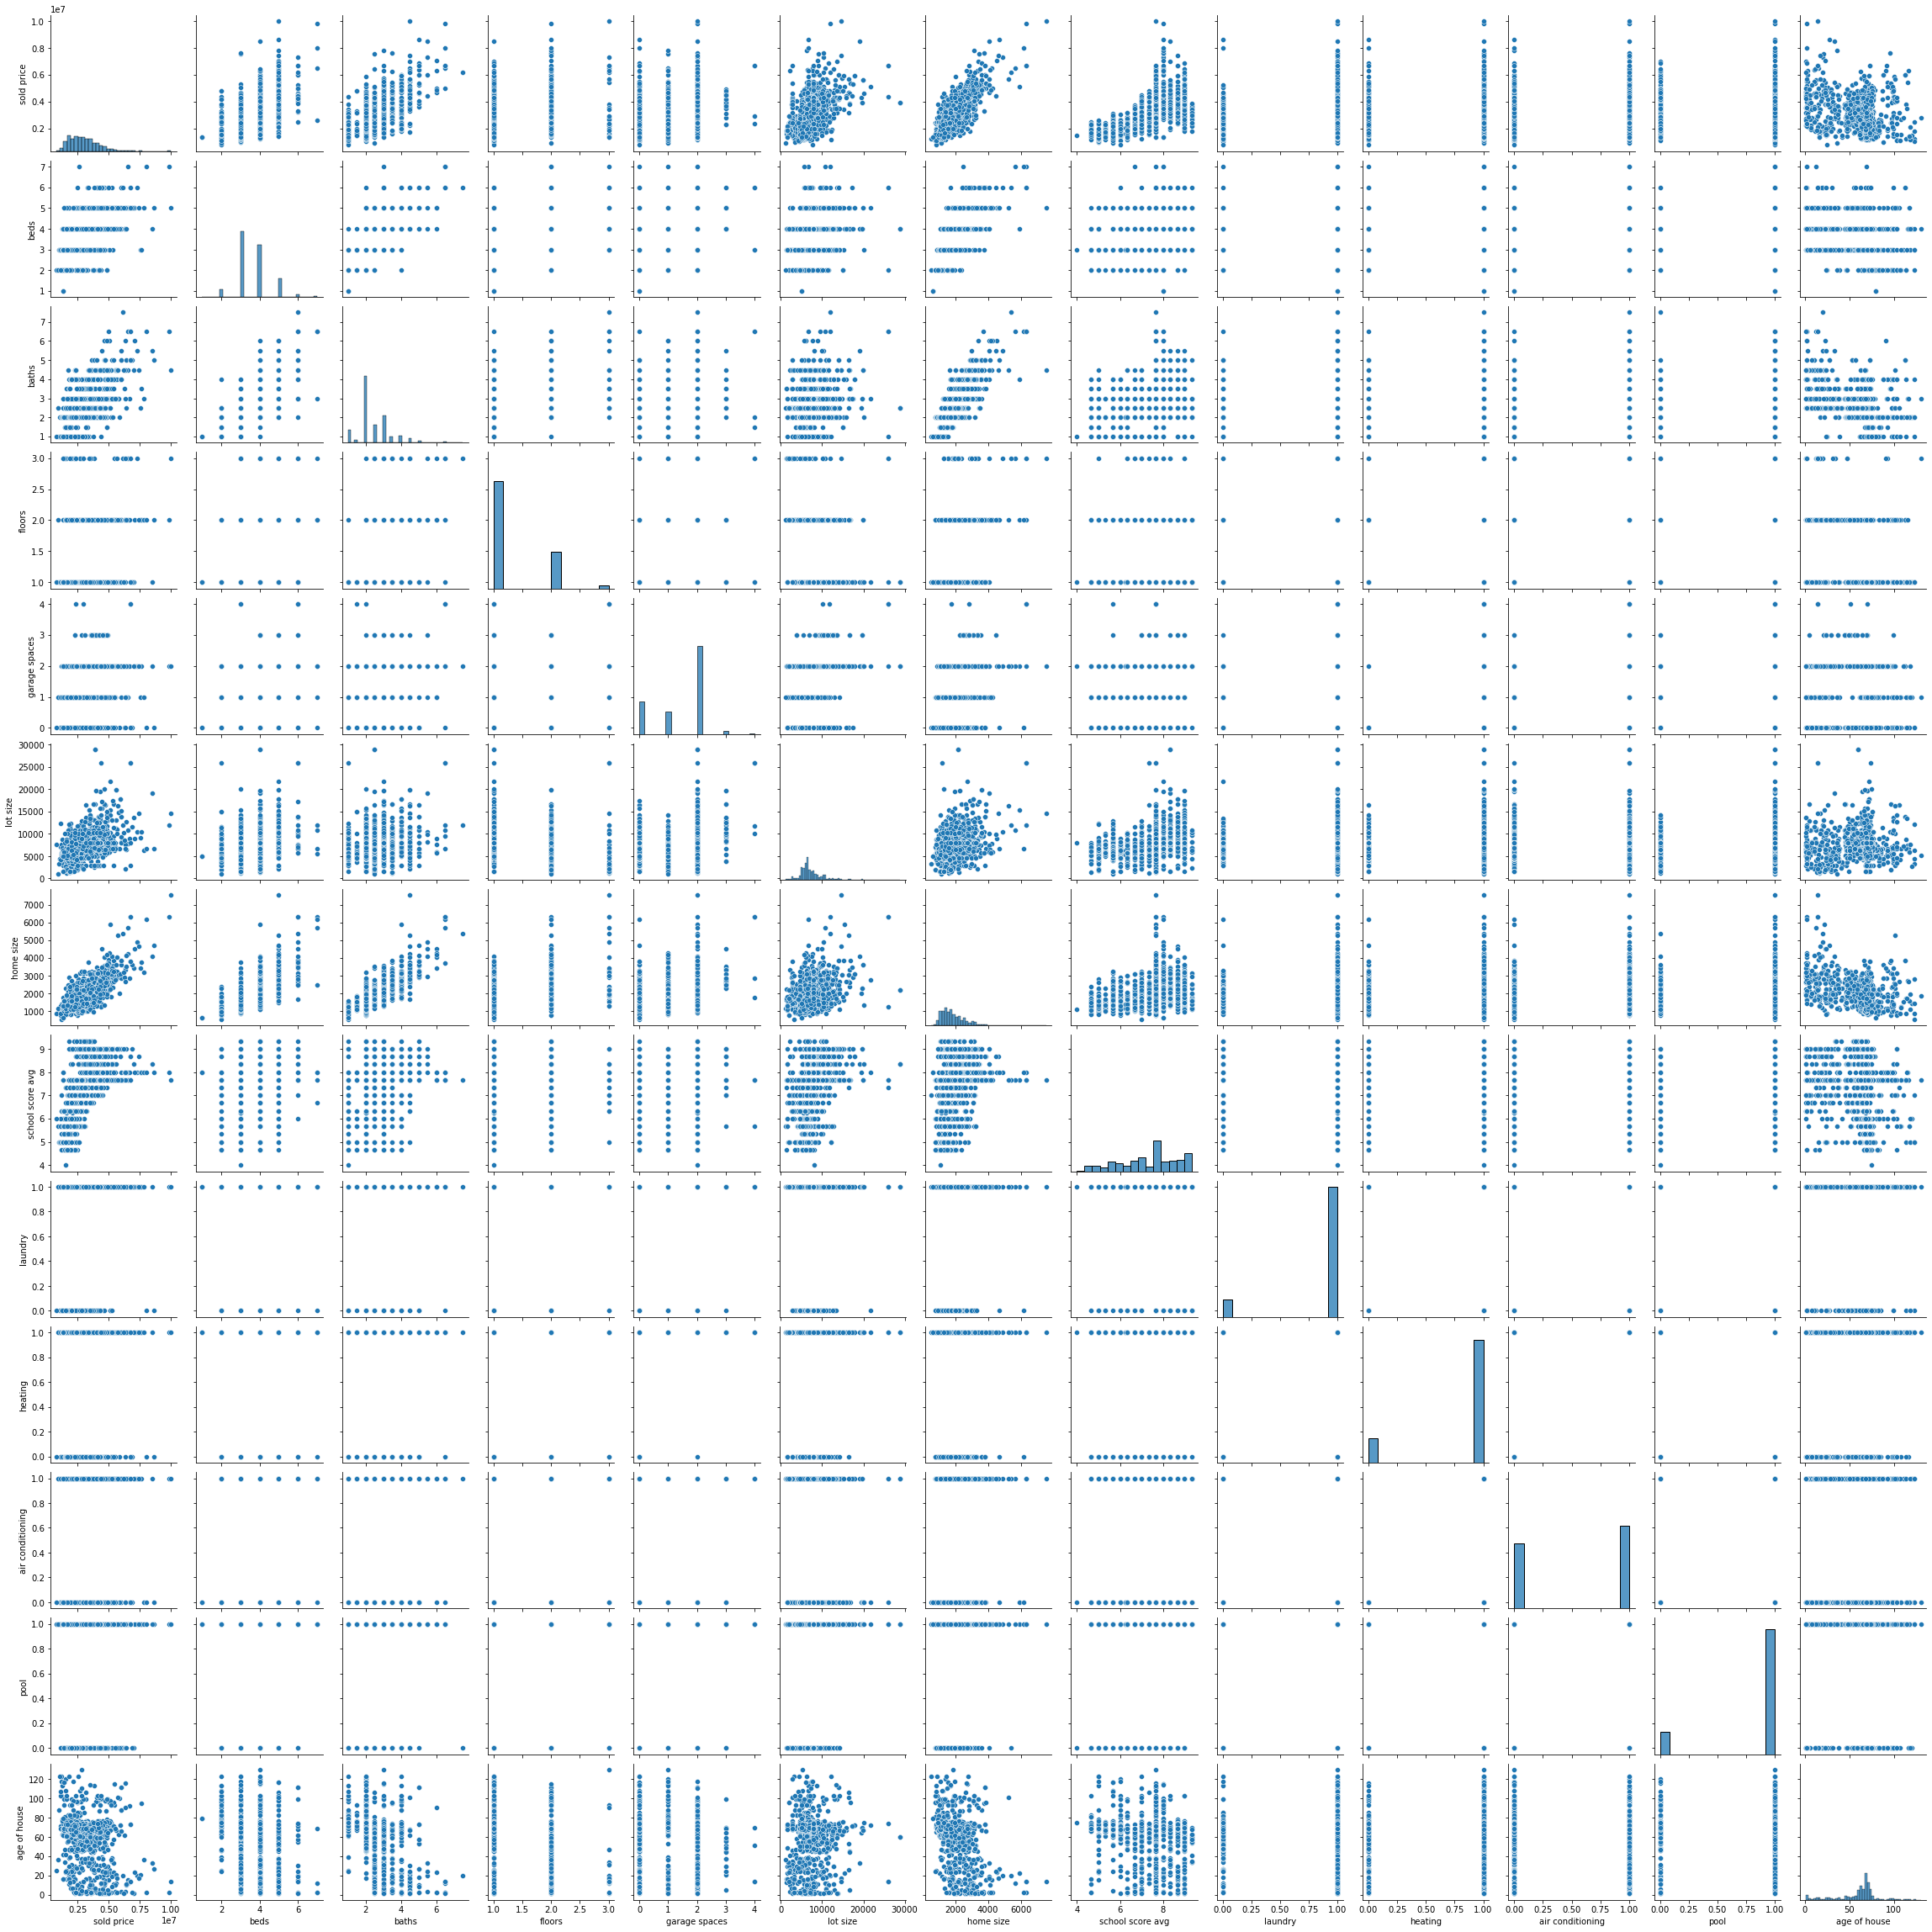

In [35]:
sns.pairplot(df_temp.drop(columns='city'));

In [36]:
bool_cols = {
                'beds': str,
                'baths': str,
                'floors': str,
                'garage spaces': str
               }
  
df_temp = df_temp.astype(bool_cols)
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1292 entries, 0 to 1439
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sold price        1292 non-null   float64
 1   beds              1292 non-null   object 
 2   baths             1292 non-null   object 
 3   floors            1292 non-null   object 
 4   garage spaces     1292 non-null   object 
 5   lot size          1292 non-null   float64
 6   home size         1292 non-null   float64
 7   school score avg  1292 non-null   float64
 8   laundry           1292 non-null   int64  
 9   heating           1292 non-null   int64  
 10  air conditioning  1292 non-null   int64  
 11  pool              1292 non-null   int64  
 12  city              1292 non-null   object 
 13  age of house      1292 non-null   float64
dtypes: float64(5), int64(4), object(5)
memory usage: 183.7+ KB


In [37]:
# df_temp['school score avg sq'] = df_temp['school score avg'] ** 2
# df_temp.info()

In [38]:
df_temp['beds'].value_counts()

3.0    576
4.0    454
5.0    163
2.0     69
6.0     24
7.0      4
1.0      2
Name: beds, dtype: int64

In [39]:
bed_count = df_temp['beds'].value_counts()

bed_one = list(bed_count[bed_count == 2].index)
df_temp['beds'] = df_temp['beds'].replace(bed_one, '1-2')

bed_two = list(bed_count[bed_count == 69].index)
df_temp['beds'] = df_temp['beds'].replace(bed_two, '1-2')

bed_six = list(bed_count[bed_count == 24].index)
df_temp['beds'] = df_temp['beds'].replace(bed_six, '6+')

bed_seven = list(bed_count[bed_count == 4].index)
df_temp['beds'] = df_temp['beds'].replace(bed_seven, '6+')

df_temp['beds'].value_counts()

3.0    576
4.0    454
5.0    163
1-2     71
6+      28
Name: beds, dtype: int64

In [40]:
df_temp['baths'].value_counts()

2.0    581
3.0    238
2.5    160
1.0    109
4.0     59
3.5     56
4.5     37
1.5     21
5.0     15
6.5      6
6.0      5
5.5      4
7.5      1
Name: baths, dtype: int64

In [41]:
bath_count = df_temp['baths'].value_counts()

bath_6plus = list(bath_count[bath_count <= 6].index)
df_temp['baths'] = df_temp['baths'].replace(bath_6plus, '6+')

df_temp['baths'].value_counts()

2.0    581
3.0    238
2.5    160
1.0    109
4.0     59
3.5     56
4.5     37
1.5     21
6+      16
5.0     15
Name: baths, dtype: int64

In [42]:
df_temp['floors'].value_counts()

1.0    942
2.0    322
3.0     28
Name: floors, dtype: int64

In [43]:
df_temp['garage spaces'].value_counts()

2    775
0    285
1    199
3     29
4      4
Name: garage spaces, dtype: int64

In [44]:
garage_count = df_temp['garage spaces'].value_counts()

garage_3plus = list(garage_count[garage_count <= 29].index)
df_temp['garage spaces'] = df_temp['garage spaces'].replace(garage_3plus, '3+')

df_temp['garage spaces'].value_counts()

2     775
0     285
1     199
3+     33
Name: garage spaces, dtype: int64

In [45]:
df_dummies = pd.get_dummies(df_temp, columns=['beds', 'baths', 'floors', 'garage spaces', 'city'], drop_first=True)
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1292 entries, 0 to 1439
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sold price          1292 non-null   float64
 1   lot size            1292 non-null   float64
 2   home size           1292 non-null   float64
 3   school score avg    1292 non-null   float64
 4   laundry             1292 non-null   int64  
 5   heating             1292 non-null   int64  
 6   air conditioning    1292 non-null   int64  
 7   pool                1292 non-null   int64  
 8   age of house        1292 non-null   float64
 9   beds_3.0            1292 non-null   uint8  
 10  beds_4.0            1292 non-null   uint8  
 11  beds_5.0            1292 non-null   uint8  
 12  beds_6+             1292 non-null   uint8  
 13  baths_1.5           1292 non-null   uint8  
 14  baths_2.0           1292 non-null   uint8  
 15  baths_2.5           1292 non-null   uint8  
 16  baths_

In [46]:
df_dummies.corr()

,sold price,lot size,home size,school score avg,laundry,heating,air conditioning,pool,age of house,beds_3.0,...,floors_2.0,floors_3.0,garage spaces_1,garage spaces_2,garage spaces_3+,city_LOS ALTOS,city_MOUNTAIN VIEW,city_PALO ALTO,city_SANTA CLARA,city_SUNNYVALE
sold price,1.000000,0.498879,0.777310,0.638529,0.029400,-0.053217,0.031581,0.101150,-0.263180,-0.402844,...,0.280418,0.094590,-0.110908,0.037377,0.134560,0.422771,-0.016187,0.430868,-0.448465,-0.244718
lot size,0.498879,1.000000,0.404453,0.342707,-0.018264,0.127620,0.061190,0.079917,0.038314,-0.233347,...,-0.042030,-0.021777,-0.163607,0.137878,0.219480,0.467210,-0.103577,0.032576,-0.171237,-0.142343
home size,0.777310,0.404453,1.000000,0.353373,0.031403,0.004105,0.190102,0.098964,-0.437768,-0.506961,...,0.465094,0.230711,-0.113520,0.052071,0.240019,0.293263,-0.042637,0.196172,-0.228380,-0.158213
school score avg,0.638529,0.342707,0.353373,1.000000,-0.050106,-0.037115,-0.052381,0.143565,-0.133315,-0.217172,...,0.149467,0.021821,-0.178707,0.077122,0.096928,0.309429,0.035140,0.349238,-0.517127,-0.264796
laundry,0.029400,-0.018264,0.031403,-0.050106,1.000000,0.211729,0.093463,0.062329,-0.015244,-0.020875,...,0.035236,0.021941,0.077556,0.074969,0.044416,-0.016045,0.121992,0.084767,0.051858,-0.105856
heating,-0.053217,0.127620,0.004105,-0.037115,0.211729,1.000000,0.508046,-0.001468,-0.035373,0.007261,...,0.019539,0.038432,0.191709,0.545861,0.072739,-0.037237,-0.021115,-0.049642,0.042211,0.045727
air conditioning,0.031581,0.061190,0.190102,-0.052381,0.093463,0.508046,1.000000,0.009122,-0.213367,-0.075999,...,0.141744,0.088776,0.079209,0.299607,0.123402,-0.022821,-0.006435,-0.123115,0.107023,0.034313
pool,0.101150,0.079917,0.098964,0.143565,0.062329,-0.001468,0.009122,1.000000,-0.054423,-0.055017,...,0.051394,0.004294,-0.074422,0.060386,0.041638,0.000623,0.063897,-0.016044,0.022527,-0.106790
age of house,-0.263180,0.038314,-0.437768,-0.133315,-0.015244,-0.035373,-0.213367,-0.054423,1.000000,0.180484,...,-0.420767,-0.213352,0.012999,-0.093339,-0.096527,0.013071,-0.077972,0.008954,0.152267,-0.022250
beds_3.0,-0.402844,-0.233347,-0.506961,-0.217172,-0.020875,0.007261,-0.075999,-0.055017,0.180484,1.000000,...,-0.329579,-0.047941,0.057294,-0.007980,-0.125470,-0.149223,0.005576,-0.151217,0.144194,0.115458


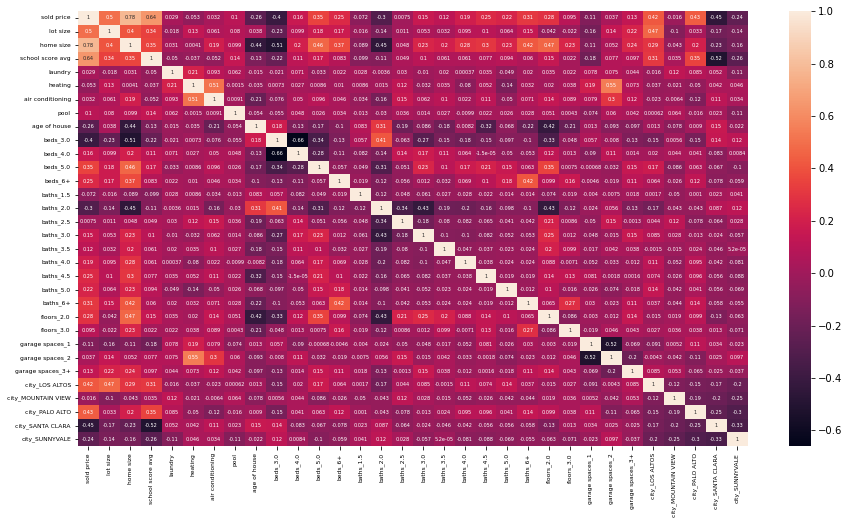

In [47]:
plt.figure(figsize=(15,8))

ax = sns.heatmap(df_dummies.corr(), annot=True, annot_kws={'size':5})
ax.set_xticklabels(ax.get_xticklabels(), size=6)
ax.set_yticklabels(ax.get_yticklabels(), size=6);

In [48]:
## SELECT TARGET AND FEATURES

x = df_dummies.drop(columns=['sold price'])
y = df_dummies['sold price']

In [49]:
x, x_test, y, y_test = train_test_split(x, y,
                                        test_size = 0.2,
                                        random_state = 42)

x_tr, x_val, y_tr, y_val = train_test_split(x, y,
                                                  test_size = 0.25,
                                                  random_state = 42)


In [50]:
## FEATURE SCALING AND FIT
std = StandardScaler()
std.fit(x_tr.values)

x_tr_std = std.transform(x_tr.values)
x_val_std = std.transform(x_val.values)

## LINEAR REGRESSION AND SCORE
lr_simple = LinearRegression()
lr_simple.fit(x_tr_std, y_tr)

lr_r2_train = lr_simple.score(x_tr_std, y_tr)
lr_r2_val = lr_simple.score(x_val_std, y_val)

print('SIMPLE LINEAR REGRESSION SCORES')

print('\nR^2 (Train): ', lr_r2_train)
print('Adj. R^2 (Train): ', adj_r2(lr_r2_train, x_tr_std))

print('\nR^2 (Validation):', lr_r2_val)
print('Adj. R^2 (Validation):', adj_r2(lr_r2_val, x_val_std))

## POLYNOMIAL LINEAR REGRESSION AND SCORE
poly = PolynomialFeatures(degree=2)

x_tr_poly = poly.fit_transform(x_tr.values)
x_val_poly = poly.transform(x_val.values)

lr_poly = LinearRegression()
lr_poly.fit(x_tr_poly, y_tr)

lr_poly_r2_train = lr_poly.score(x_tr_poly, y_tr)
lr_poly_r2_val = lr_poly.score(x_val_poly, y_val)

print('\nLINEAR REGRESSION W/POLYNOMIAL FEATURES SCORES')

print('\nR^2 (Train): ', lr_poly_r2_train)
print('Adj. R^2 (Train): ', adj_r2(lr_poly_r2_train, x_tr_poly))

print('\nR^2 (Validation):', lr_poly_r2_val)
print('Adj. R^2 (Validation):', adj_r2(lr_poly_r2_val, x_val_poly))

## RIDGE REGRESSION AND SCORE
alphas = 10**np.linspace(-4,4,200)

lr_ridge = RidgeCV(alphas = alphas, cv=5)
lr_ridge.fit(x_tr_std, y_tr)

lr_ridge_r2_train = lr_ridge.score(x_tr_std, y_tr)
lr_ridge_r2_val = lr_ridge.score(x_val_std, y_val)

print('\nRIDGE REGRESSION SCORES')

print('\nR^2 (Train): ', lr_ridge_r2_train)
print('Adj. R^2 (Train): ', adj_r2(lr_ridge_r2_train, x_tr_std))

print('\nR^2 (Validation):', lr_ridge_r2_val)
print('Adj. R^2 (Validation):', adj_r2(lr_ridge_r2_val, x_val_std))

## LASSO REGRESSION
lr_lasso = LassoCV(alphas = alphas, cv = 5)
lr_lasso.fit(x_tr_std, y_tr)

lr_lasso_r2_train = lr_lasso.score(x_tr_std, y_tr)
lr_lasso_r2_val = lr_lasso.score(x_val_std, y_val)

print('\nLASSO REGRESSION SCORES')

print('\nR^2 (Train): ', lr_lasso_r2_train)
print('Adj. R^2 (Train): ', adj_r2(lr_lasso_r2_train, x_tr_std))

print('\nR^2 (Validation):', lr_lasso_r2_val)
print('Adj. R^2 (Validation):', adj_r2(lr_lasso_r2_val, x_val_std))

## ELASTIC NET REGRESSION
lr_elastic = ElasticNetCV(l1_ratio = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], 
                          alphas = alphas, 
                          cv=5,
                          random_state=42)

lr_elastic.fit(x_tr_std, y_tr)

lr_elastic_r2_train = lr_elastic.score(x_tr_std, y_tr)
lr_elastic_r2_val = lr_elastic.score(x_val_std, y_val)

print('\nELASTIC NET REGRESSION SCORES')

print('\nR^2 (Train): ', lr_elastic_r2_train)
print('Adj. R^2 (Train): ', adj_r2(lr_elastic_r2_train, x_tr_std))

print('\nR^2 (Validation):', lr_elastic_r2_val)
print('Adj. R^2 (Validation):', adj_r2(lr_elastic_r2_val, x_val_std))


SIMPLE LINEAR REGRESSION SCORES

R^2 (Train):  0.8726305366224835
Adj. R^2 (Train):  0.8673091709018594

R^2 (Validation): 0.8246925178187167
Adj. R^2 (Validation): 0.8007518484459423

LINEAR REGRESSION W/POLYNOMIAL FEATURES SCORES

R^2 (Train):  0.9617388271679526
Adj. R^2 (Train):  0.8792820955135809

R^2 (Validation): 0.3011695182627303
Adj. R^2 (Validation): 1.6677713492156134

RIDGE REGRESSION SCORES

R^2 (Train):  0.8723971505448282
Adj. R^2 (Train):  0.8670660341929275

R^2 (Validation): 0.8270763276056528
Adj. R^2 (Validation): 0.8034612005385833

LASSO REGRESSION SCORES

R^2 (Train):  0.8707295447853287
Adj. R^2 (Train):  0.8653287575728559

R^2 (Validation): 0.8291398122868823
Adj. R^2 (Validation): 0.8058064826872935

ELASTIC NET REGRESSION SCORES

R^2 (Train):  0.8723189997557083
Adj. R^2 (Train):  0.8669846183438847

R^2 (Validation): 0.8273898944636828
Adj. R^2 (Validation): 0.8038175893023356


In [51]:
## LINEAR REGRESSION MAE
print('\nSIMPLE LINEAR REGRESSION SCORES')
print('\nMean Absolute Error (Train): ', mean_absolute_error(y_tr, lr_simple.predict(x_tr_std)))
print('\nMean Absolute Error (Validation):', mean_absolute_error(y_val, lr_simple.predict(x_val_std)))

## POLYNOMIAL LINEAR REGRESSION MAE
print('\nLINEAR REGRESSION W/POLYNOMIAL FEATURES SCORES')
print('\nMean Absolute Error (Train): ', mean_absolute_error(y_tr, lr_poly.predict(x_tr_poly)))
print('\nMean Absolute Error (Validation):', mean_absolute_error(y_val, lr_poly.predict(x_val_poly)))

## RIDGE REGRESSION MAE
print('\nRIDGE REGRESSION SCORES')
print('\nMean Absolute Error (Train): ', mean_absolute_error(y_tr, lr_ridge.predict(x_tr_std)))
print('\nMean Absolute Error (Validation):', mean_absolute_error(y_val, lr_ridge.predict(x_val_std)))

## LASSO REGRESSION MAE
print('\nLASSO REGRESSION SCORES')
print('\nMean Absolute Error (Train): ', mean_absolute_error(y_tr, lr_lasso.predict(x_tr_std)))
print('\nMean Absolute Error (Validation):', mean_absolute_error(y_val, lr_lasso.predict(x_val_std)))

## ELASTIC NET REGRESSION MAE
print('\nELASTIC NET REGRESSION SCORES')
print('\nMean Absolute Error (Train): ', mean_absolute_error(y_tr, lr_elastic.predict(x_tr_std)))
print('\nMean Absolute Error (Validation):', mean_absolute_error(y_val, lr_elastic.predict(x_val_std)))


SIMPLE LINEAR REGRESSION SCORES

Mean Absolute Error (Train):  328536.35717538337

Mean Absolute Error (Validation): 356534.6512499042

LINEAR REGRESSION W/POLYNOMIAL FEATURES SCORES

Mean Absolute Error (Train):  178351.25204000712

Mean Absolute Error (Validation): 525829.5406253253

RIDGE REGRESSION SCORES

Mean Absolute Error (Train):  327270.6597989413

Mean Absolute Error (Validation): 354542.0875249892

LASSO REGRESSION SCORES

Mean Absolute Error (Train):  331096.7483811271

Mean Absolute Error (Validation): 351901.5103783392

ELASTIC NET REGRESSION SCORES

Mean Absolute Error (Train):  327121.4067848912

Mean Absolute Error (Validation): 354251.80592353246


In [52]:
## LINEAR REGRESSION MAE
print('\nSIMPLE LINEAR REGRESSION SCORES')
print('\nRoot Mean Squared Error (Train): ', mean_squared_error(y_tr, lr_simple.predict(x_tr_std), squared=False))
print('\nRoot Mean Squared Error (Validation):', mean_squared_error(y_val, lr_simple.predict(x_val_std), squared=False))

## POLYNOMIAL LINEAR REGRESSION MAE
print('\nLINEAR REGRESSION W/POLYNOMIAL FEATURES SCORES')
print('\nRoot Mean Squared Error (Train): ', mean_squared_error(y_tr, lr_poly.predict(x_tr_poly), squared=False))
print('\nRoot Mean Squared Error (Validation):', mean_squared_error(y_val, lr_poly.predict(x_val_poly), squared=False))

## RIDGE REGRESSION MAE
print('\nRIDGE REGRESSION SCORES')
print('\nRoot Mean Squared Error (Train): ', mean_squared_error(y_tr, lr_ridge.predict(x_tr_std), squared=False))
print('\nRoot Mean Squared Error (Validation):', mean_squared_error(y_val, lr_ridge.predict(x_val_std), squared=False))

## LASSO REGRESSION MAE
print('\nLASSO REGRESSION SCORES')
print('\nRoot Mean Squared Error (Train): ', mean_squared_error(y_tr, lr_lasso.predict(x_tr_std), squared=False))
print('\nRoot Mean Squared Error (Validation):', mean_squared_error(y_val, lr_lasso.predict(x_val_std), squared=False))

## ELASTIC NET REGRESSION MAE
print('\nELASTIC NET REGRESSION SCORES')
print('\nRoot Mean Squared Error (Train): ', mean_squared_error(y_tr, lr_elastic.predict(x_tr_std), squared=False))
print('\nRoot Mean Squared Error (Validation):', mean_squared_error(y_val, lr_elastic.predict(x_val_std), squared=False))


SIMPLE LINEAR REGRESSION SCORES

Root Mean Squared Error (Train):  450137.5209307604

Root Mean Squared Error (Validation): 462063.67611954635

LINEAR REGRESSION W/POLYNOMIAL FEATURES SCORES

Root Mean Squared Error (Train):  246712.80696505672

Root Mean Squared Error (Validation): 922544.9221357718

RIDGE REGRESSION SCORES

Root Mean Squared Error (Train):  450549.73806183925

Root Mean Squared Error (Validation): 458911.3805177863

LASSO REGRESSION SCORES

Root Mean Squared Error (Train):  453484.235571704

Root Mean Squared Error (Validation): 456165.08626451396

ELASTIC NET REGRESSION SCORES

Root Mean Squared Error (Train):  450687.68728523975

Root Mean Squared Error (Validation): 458495.1139331558


In [53]:
## .predict() on train data
lr_simple_std_predict = lr_simple.predict(x_tr_std)
lr_poly_std_predict = lr_poly.predict(x_tr_poly)
lr_ridge_std_predict = lr_ridge.predict(x_tr_std)
lr_lasso_std_predict = lr_lasso.predict(x_tr_std)
lr_elastic_std_predict = lr_elastic.predict(x_tr_std)

In [54]:
## .predict() on validation data
lr_simple_val_predict = lr_simple.predict(x_val_std)
lr_poly_val_predict = lr_poly.predict(x_val_poly)
lr_ridge_val_predict = lr_ridge.predict(x_val_std)
lr_lasso_val_predict = lr_lasso.predict(x_val_std)
lr_elastic_val_predict = lr_elastic.predict(x_val_std)

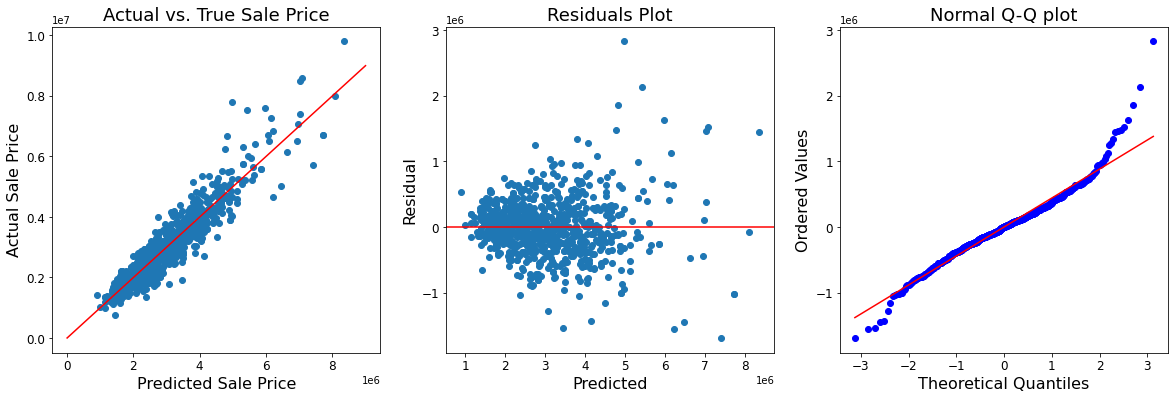

In [55]:
## LINEAR REGRESSION (TRAIN)
diagnostic_plots(x_tr_std, y_tr, lr_simple_std_predict)

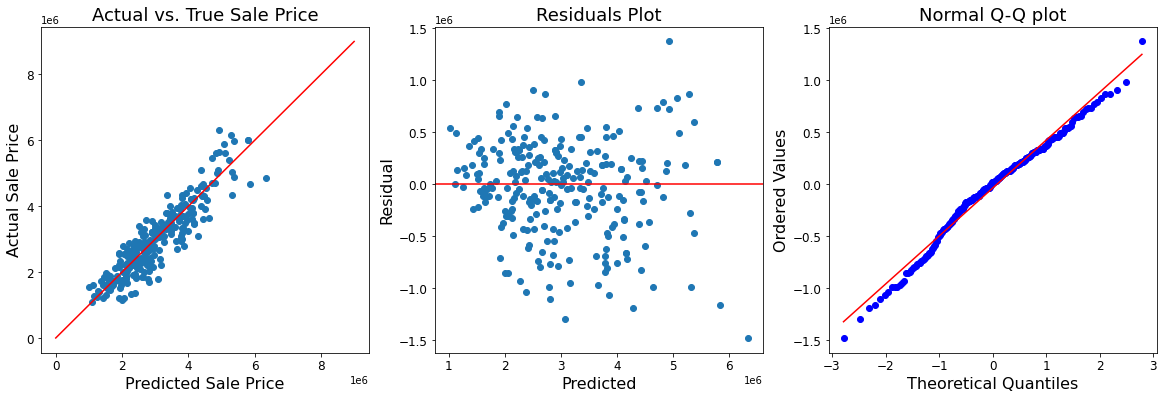

In [56]:
## LINEAR REGRESSION (VALIDATION)
diagnostic_plots(x_val_std, y_val, lr_simple_val_predict)

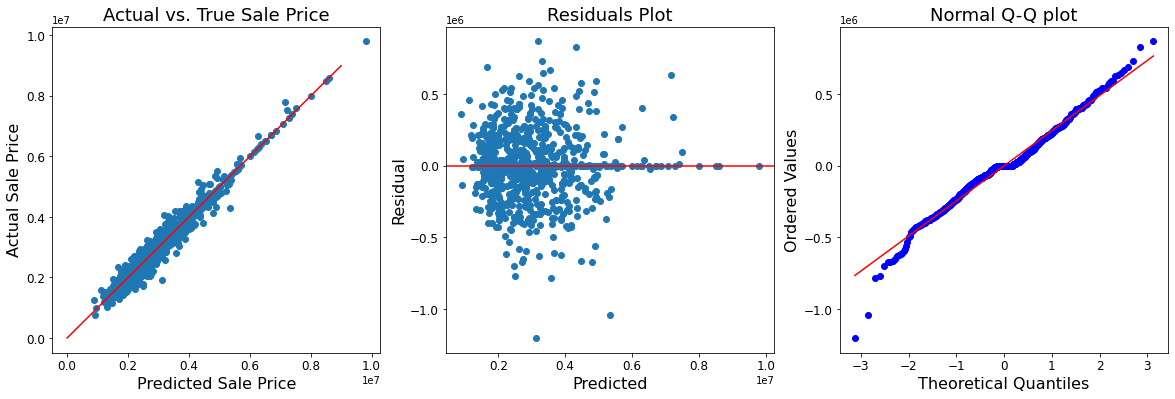

In [57]:
## POLYNOMIAL LINEAR REGRESSION (TRAIN)
diagnostic_plots(x_tr_std, y_tr, lr_poly_std_predict)

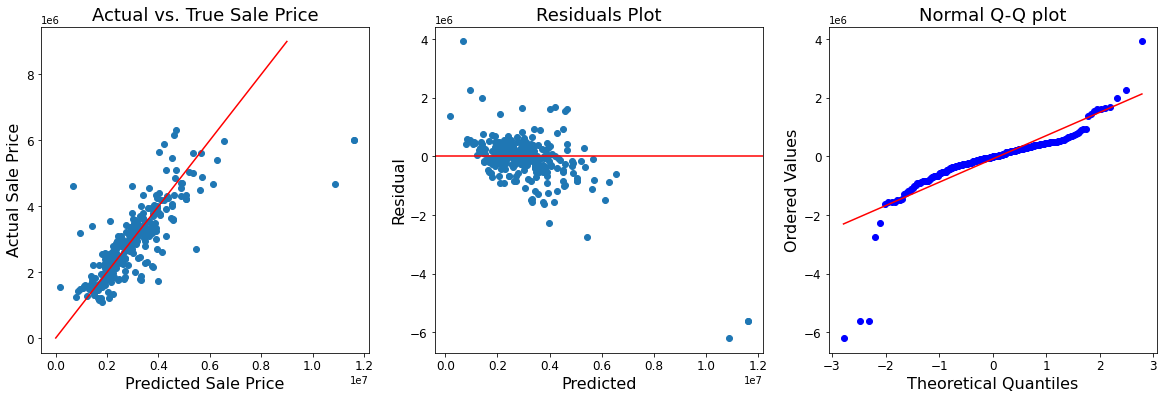

In [58]:
## POLYNOMIAL LINEAR REGRESSION (VALIDATION)
diagnostic_plots(x_val_std, y_val, lr_poly_val_predict)

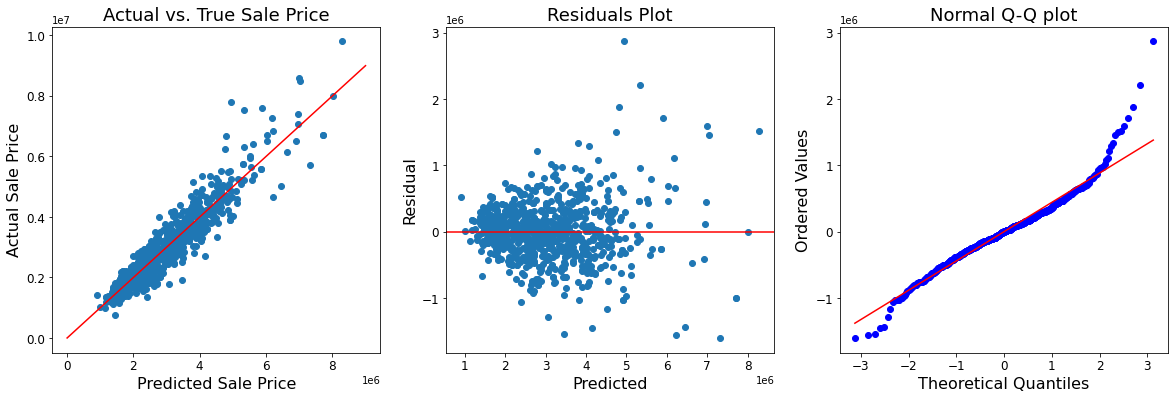

In [59]:
## RIDGE REGRESSION (TRAIN)
diagnostic_plots(x_tr_std, y_tr, lr_ridge_std_predict)

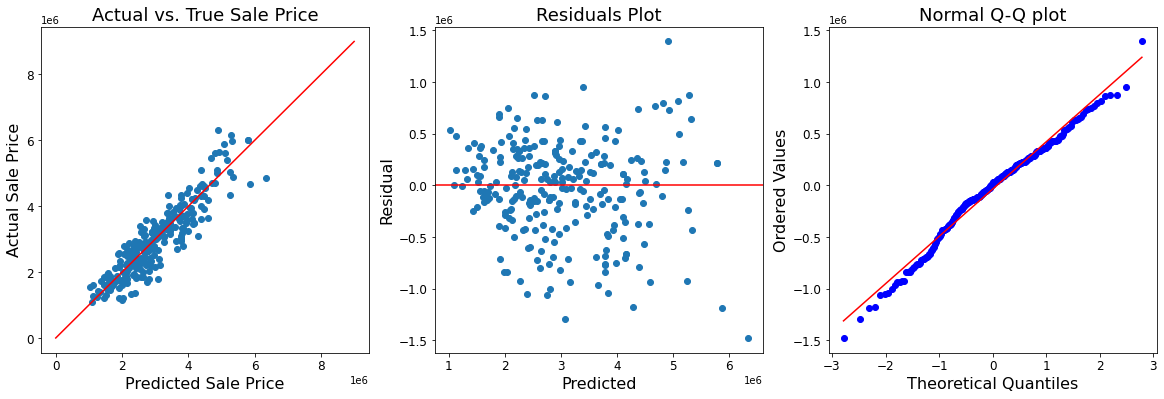

In [60]:
## RIDGE REGRESSION (VALIDATION)
diagnostic_plots(x_val_std, y_val, lr_ridge_val_predict)

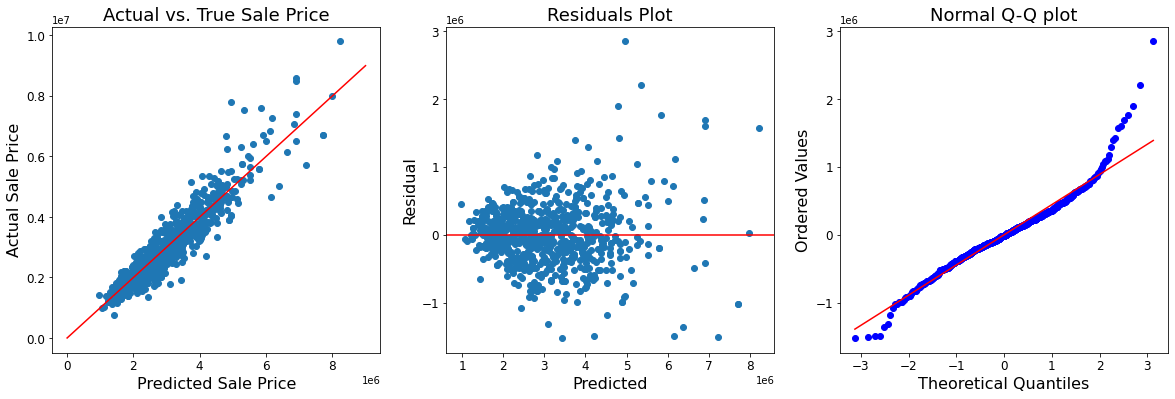

In [61]:
## LASSO REGRESSION (TRAIN)
diagnostic_plots(x_tr_std, y_tr, lr_lasso_std_predict)

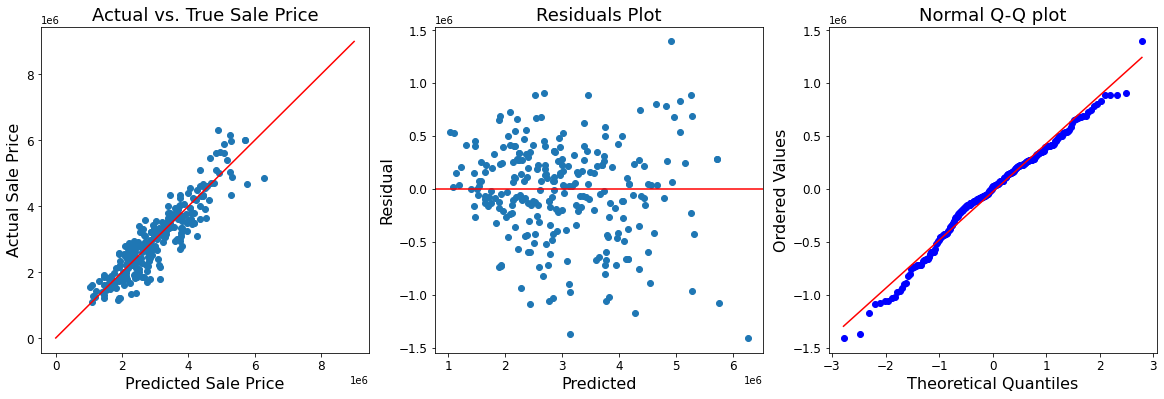

In [62]:
## LASSO REGRESSION (VALIDATION)
diagnostic_plots(x_val_std, y_val, lr_lasso_val_predict)

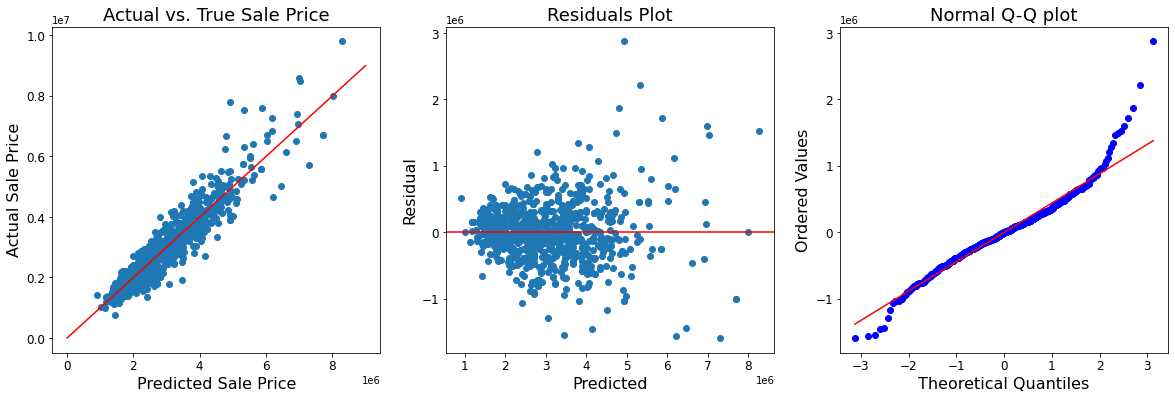

In [63]:
## ELASTIC REGRESSION (TRAIN)
diagnostic_plots(x_tr_std, y_tr, lr_elastic_std_predict)

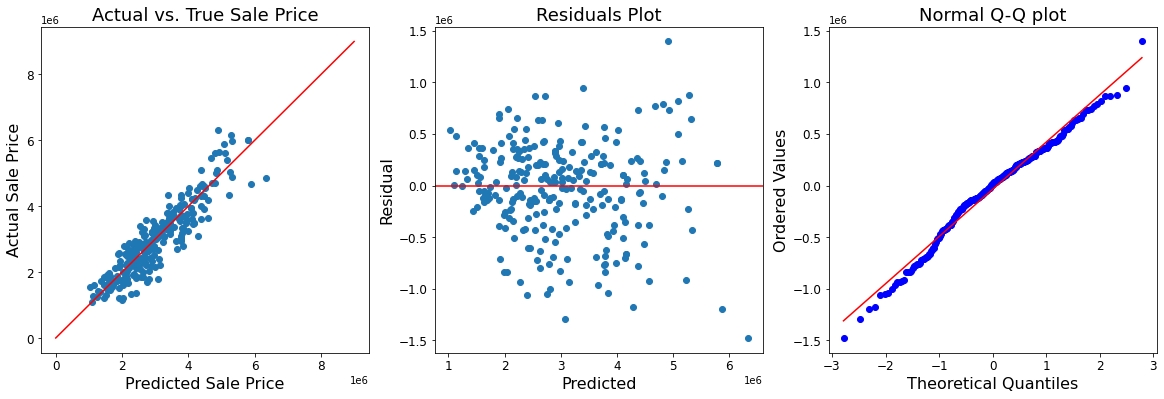

In [64]:
## ELASTIC NET REGRESSION (VALIDATION)
diagnostic_plots(x_val_std, y_val, lr_elastic_val_predict)

In [65]:
for feature, coef in zip(x_tr.columns, lr_elastic.coef_):
    print(feature, ':', f'{coef:.2f}')

lot size : 135432.71
home size : 796116.84
school score avg : 266532.77
laundry : 10797.54
heating : -58399.56
air conditioning : -31887.99
pool : 15832.35
age of house : 9681.01
beds_3.0 : 55190.79
beds_4.0 : 20590.60
beds_5.0 : -24358.28
beds_6+ : -96820.03
baths_1.5 : -15724.58
baths_2.0 : -45979.65
baths_2.5 : -69796.99
baths_3.0 : -52654.73
baths_3.5 : -25434.12
baths_4.0 : -92921.78
baths_4.5 : -12346.99
baths_5.0 : 36253.50
baths_6+ : 59814.98
floors_2.0 : -23548.75
floors_3.0 : -105134.89
garage spaces_1 : 26832.08
garage spaces_2 : 66330.51
garage spaces_3+ : -34481.62
city_LOS ALTOS : 224400.31
city_MOUNTAIN VIEW : 114848.05
city_PALO ALTO : 364290.60
city_SANTA CLARA : -76955.18
city_SUNNYVALE : 33279.07


In [66]:
## CHOOSING THE BEST MODEL, COMBINE TRAIN AND VALIDATION, RE-FIT, SCORE

In [67]:
## FEATURE SCALING AND FIT
std = StandardScaler()
std.fit(x_tr.values)

x_std = std.transform(x.values)
x_test_std = std.transform(x_test.values)

## ELASTIC NET REGRESSION
alphas = 10**np.linspace(-4,4,200)

lr_elastic = ElasticNetCV(l1_ratio = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], 
                          alphas = alphas, 
                          cv=5,
                          random_state=42)

lr_elastic.fit(x_std, y)

lr_elastic_r2 = lr_elastic.score(x_std, y)
lr_elastic_r2_test = lr_elastic.score(x_test_std, y_test)

print('\nELASTIC NET REGRESSION SCORES')

print('\nR^2 (Train+Validation): ', lr_elastic_r2)
print('Adj. R^2 (Train+Validation): ', adj_r2(lr_elastic_r2, x_std))

print('\nR^2 (Test):', lr_elastic_r2_test)
print('Adj. R^2 (Test):', adj_r2(lr_elastic_r2_test, x_test_std))



ELASTIC NET REGRESSION SCORES

R^2 (Train+Validation):  0.8639171188861515
Adj. R^2 (Train+Validation):  0.8597027639265817

R^2 (Test): 0.8010066643737235
Adj. R^2 (Test): 0.7738313630326901


In [68]:
## ELASTIC NET REGRESSION MAE
print('\nELASTIC NET REGRESSION SCORES')
print('\nMean Absolute Error (Train+Validation): ', mean_absolute_error(y, lr_elastic.predict(x_std)))
print('\nMean Absolute Error (Test):', mean_absolute_error(y_test, lr_elastic.predict(x_test_std)))



ELASTIC NET REGRESSION SCORES

Mean Absolute Error (Train+Validation):  331575.09262305655

Mean Absolute Error (Test): 398667.2442588128


In [69]:
## ELASTIC NET REGRESSION MAE
print('\nELASTIC NET REGRESSION SCORES')
print('\nRoot Mean Squared Error (Train+Validation): ', mean_squared_error(y, lr_elastic.predict(x_std), squared=False))
print('\nRoot Mean Squared Error (Test):', mean_squared_error(y_test, lr_elastic.predict(x_test_std), squared=False))



ELASTIC NET REGRESSION SCORES

Root Mean Squared Error (Train+Validation):  451568.13409470924

Root Mean Squared Error (Test): 543226.828422165


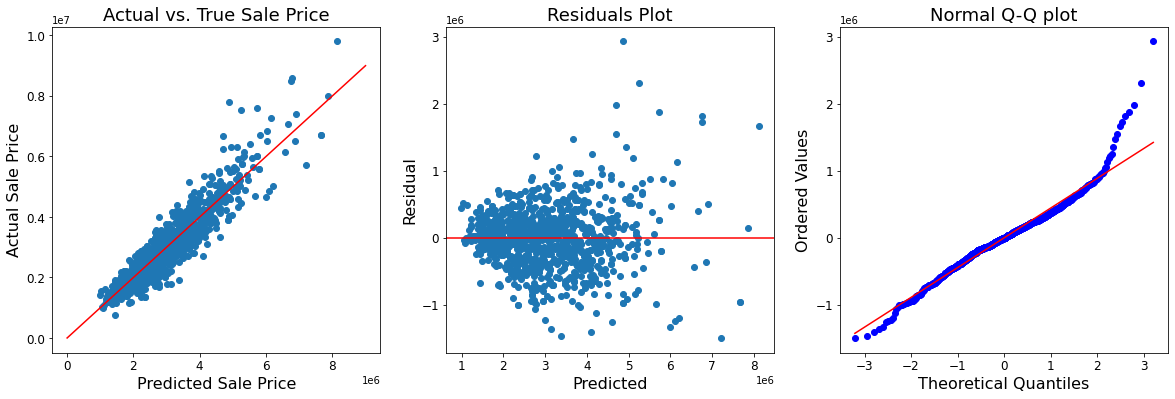

In [70]:
## ELASTIC NET REGRESSION (TEST) DIAGNOSTIC PLOT
lr_elastic_test_predict = lr_elastic.predict(x_std)

diagnostic_plots(x_std, y, lr_elastic_test_predict)

In [71]:
## STANDARDIZED COEFFICIENTS FOR FEATURES IN OUR ELASTIC NET MODEL
for feature, coef in zip(x.columns, lr_elastic.coef_):
    print(feature, ':', f'{coef:.2f}')

lot size : 130766.26
home size : 773471.44
school score avg : 269845.16
laundry : 3076.32
heating : -39490.85
air conditioning : -18532.17
pool : 15432.62
age of house : 0.00
beds_3.0 : 21291.99
beds_4.0 : 0.00
beds_5.0 : -31173.91
beds_6+ : -71899.62
baths_1.5 : -0.00
baths_2.0 : 0.00
baths_2.5 : -28218.86
baths_3.0 : -0.00
baths_3.5 : 0.00
baths_4.0 : -43796.74
baths_4.5 : 20622.92
baths_5.0 : 37970.59
baths_6+ : 52139.99
floors_2.0 : -36938.23
floors_3.0 : -96698.00
garage spaces_1 : 17165.13
garage spaces_2 : 42698.15
garage spaces_3+ : -37222.90
city_LOS ALTOS : 205731.06
city_MOUNTAIN VIEW : 110700.70
city_PALO ALTO : 336679.56
city_SANTA CLARA : -73019.63
city_SUNNYVALE : 29654.19


In [72]:
# sns.set_style('white')

# sns.histplot(df_temp['sold price'], color='darkred')
# plt.title('Distribution of Homes Sold', fontsize=16)
# plt.xlabel('Sold Price', fontsize=16)
# plt.ylabel('Frequency', fontsize=16);

In [73]:
# sns.histplot(np.log10(df_temp['sold price']), color='darkred')
# plt.title('Distribution of Homes Sold', fontsize=16)
# plt.xlabel('Sold Price', fontsize=16)
# plt.ylabel('Frequency', fontsize=16);